# Adversarial machine learning

В самом широком понимании этого слова, это наука об атаках на алгоритмы машинного обучения и способах защиты от них

В данной работе будет рассмотрен пример такой атаки. Сначала будет обучена модель для распознавания цифр на картинке, затем будут сформированы примеры (adversarial examples), изменяющие показания модели

Работа выполнена студентом БИБ233 МИЭМ НИУ ВШЭ Коноваловым Матвеем



## Обучение модели
Сначала скачаем [модель](https://github.com/ultralytics/ultralytics/blob/main/docs/en/models/yolov8.md)

Была выбрана модель YOLOv8, предназначенная для задачи классификации, имеющая малое количество параметров. Большие модели могли бы замедлить эксперимент, меньшие представляли бы меньше интереса

In [1]:
from ultralytics import YOLO

model = YOLO("yolov8s-cls.pt")
model.info()

KeyboardInterrupt: 

Затем скачаем датасет и приведем его в формат, совместимый с YOLO

In [3]:
from datasets import load_dataset
from pathlib import Path

ds = load_dataset("ufldl-stanford/svhn", "cropped_digits")
root = Path("datasets/svhn_cls")
splits = ["train", "test"]

for split in splits:
    split_ds = ds[split]
    for i, example in enumerate(split_ds):
        label = str(example["label"])
        out_dir = root / split / label
        out_dir.mkdir(parents=True, exist_ok=True)
        example["image"].save(out_dir / f"{i}.png")

Обучим модель

In [ ]:
model.train(data=root,
            epochs=50,
            batch=128,
            verbose=False)

Посмотрим качество модели

In [4]:
model.val()

Ultralytics 8.3.153  Python-3.11.9 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,088,010 parameters, 0 gradients, 12.5 GFLOPs
WARNING Dataset 'split=val' not found, using 'split=test' instead.
train: C:\Users\ok__\PycharmProjects\MLSecOps\datasets\svhn_cls\train... found 73257 images in 10 classes  
val: C:\Users\ok__\PycharmProjects\MLSecOps\datasets\svhn_cls\test... found 26032 images in 10 classes  
test: C:\Users\ok__\PycharmProjects\MLSecOps\datasets\svhn_cls\test... found 26032 images in 10 classes  
val: Fast image access  (ping: 0.00.0 ms, read: 21.05.2 MB/s, size: 1.7 KB)


val: Scanning C:\Users\ok__\PycharmProjects\MLSecOps\datasets\svhn_cls\test... 26032 images, 0 corrupt: 100%|██████████| 26032/26032 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1627/1627 [00:11<00:00, 145.36it/s]


                   all       0.97      0.997
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000276AF828FD0>
curves: []
curves_results: []
fitness: 0.9836931526660919
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9702289700508118, 'metrics/accuracy_top5': 0.9971573352813721, 'fitness': 0.9836931526660919}
save_dir: WindowsPath('runs/classify/val2')
speed: {'preprocess': 0.052707052859466745, 'inference': 0.29765943838272885, 'loss': 0.0003550591580862303, 'postprocess': 0.000511593423185487}
task: 'classify'
top1: 0.9702289700508118
top5: 0.9971573352813721

Отлично, модель обучилась и имеет долю правильных ответов 97%, при этом правильный ответ находится в топ 5 в 99,7% случаев
Обученную модель можно скачать по [ссылке](https://disk.360.yandex.ru/d/r-5SqYBdwTfuuQ) (рекомендуется положить её в папку models)



## Проведение атаки
Для начала зададим все нужные параметры


In [2]:
from pathlib import Path
import torch
import numpy as np
import random

MODEL_PATH = Path('models/best.pt')
DATA_DIR = Path("datasets/svhn_cls/test")
N_SAMPLES = 1000 # Количество картинок, к которым будем генерировать adv. примеры
EPS = 8/255 # Гиперпараметр атаки (насколько сильно искажаем изображение: большие значения видны визуально)
IMG_SIZE = 224
OUT_DIR = Path('Adv_examples')
OUT_DIR.mkdir(exist_ok=True, parents=True)
SEED = 17
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Положим [модель](https://disk.360.yandex.ru/d/r-5SqYBdwTfuuQ) в папку, указанную выше и считаем её.

Указав функцию потерь, добавим модель в PyTorchClassifier, с которым уже умеет работать ART.

Однако, напрямую её туда положить нельзя (т.к. ART ожидает только логиты, а YOLO выдаёт и другие результаты в ответе), так что сделаем это через адаптер

In [3]:
class YoloClsAdapter(torch.nn.Module):
    def __init__(self, core_model):
        super().__init__()
        self.core = core_model

    def forward(self, x):
        out = self.core(x)
        if isinstance(out, (list, tuple)):
            out = out[0]
        return out

In [4]:
from ultralytics import YOLO
from art.estimators.classification import PyTorchClassifier

yolo  = YOLO(MODEL_PATH)
adapter = YoloClsAdapter(yolo.model).to(device).eval()

loss = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=adapter,
    loss=loss,
    nb_classes=10,
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    clip_values=(0.0, 1.0),
    device_type=device
)

Считаем датасет в формате, понятном ART

In [5]:
from PIL import Image

all_files = list(DATA_DIR.glob("*/*.png"))
assert all_files, f"Ничего не найдено в {DATA_DIR}"

idx_files = random.sample(all_files, N_SAMPLES) # Выбираем N_SAMPLES картинок

x, y = [], []
for fp in idx_files:
    img = Image.open(fp).convert("RGB")
    arr = yolo.model.transforms(img)
    x.append(arr)
    y.append(int(fp.parent.name))

x = np.stack(x, axis=0)
y = np.asarray(y)

Наконец, самое интересное: проводим атаку и считаем процент успешности

In [6]:
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=classifier, eps=EPS)
x_adv  = attack.generate(x=x)

pred_orig = classifier.predict(x)
pred_adv  = classifier.predict(x_adv)

label_orig = np.argmax(pred_orig, axis=1)
label_adv  = np.argmax(pred_adv, axis=1)

orig_correct = label_orig == y
asr          = (orig_correct & (label_adv != y)).sum() / orig_correct.sum()

print(f'Изначальный accuracy модели: {orig_correct.mean()*100:.2f}%')
print(f"Процент успешности атаки: {asr*100:.2f}%")

Изначальный accuracy модели: 97.30%
Процент успешности атаки: 69.06%


Результат получили отличный. Теперь визуально проверим, насколько видны изменения в изображениях

Выведем 10 картинок, которые до атаки предсказывались правильно, а после атаки стали предсказываться иначе

,Исходное изображение,Изменённое изображение
0,5 (99.54%),1 (51.94%)
1,3 (99.77%),1 (41.64%)
2,2 (99.99%),1 (37.45%)
3,2 (99.92%),1 (41.40%)
4,9 (99.23%),2 (30.36%)
5,8 (75.64%),1 (60.13%)
6,5 (99.94%),1 (47.70%)
7,7 (99.37%),2 (37.21%)
8,2 (99.34%),1 (50.23%)
9,0 (99.90%),1 (54.27%)

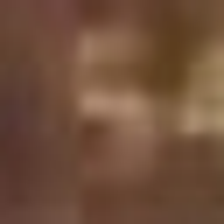
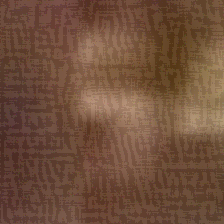
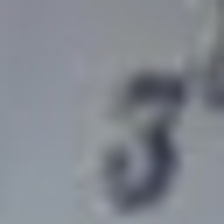
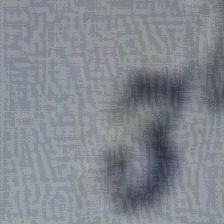
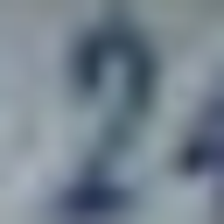
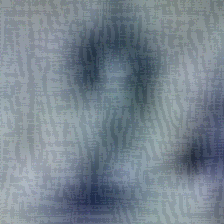
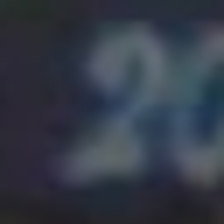
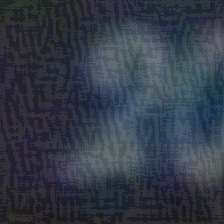
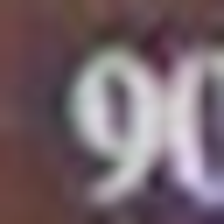
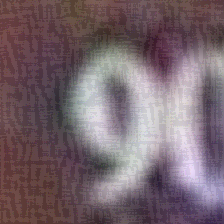
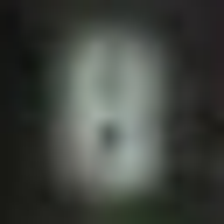
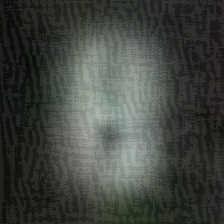
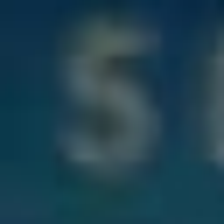
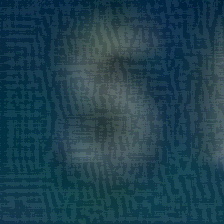
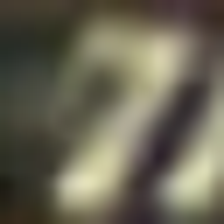
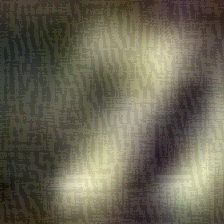
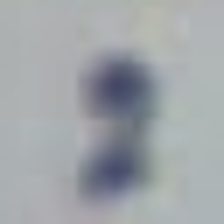
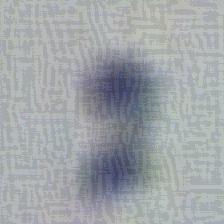
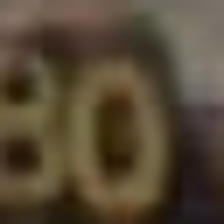
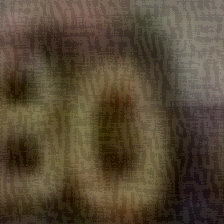

In [37]:
import base64, io
import pandas as pd
from IPython.display import HTML

# Выбираем наши 10 примеров с изначально правильным предсказанием, изменившимся на неправильное
success_idxs = np.where((label_orig == y) & (label_adv != y))[0][:10]
assert len(success_idxs), "Нет успешных adversarial-примеров!"

rows = []
for idx in success_idxs:
    # Подготовим изображения
    orig_arr = (x[idx].transpose(1, 2, 0) * 255).astype(np.uint8) # CHW → HWC
    adv_arr  = (x_adv[idx].transpose(1, 2, 0) * 255).clip(0, 255).astype(np.uint8)

    def arr_to_b64(arr):
        buf = io.BytesIO()
        Image.fromarray(arr).save(buf, format="PNG")
        return base64.b64encode(buf.getvalue()).decode()

    orig_b64 = arr_to_b64(orig_arr)
    adv_b64  = arr_to_b64(adv_arr)

    # Извлекаем классы и уверенности
    orig_class = label_orig[idx]
    adv_class  = label_adv[idx]
    orig_conf  = float(pred_orig[idx, orig_class])
    adv_conf   = float(pred_adv[idx, adv_class])

    rows.append({
        "Исходное изображение": (
            f'<img src="data:image/png;base64,{orig_b64}" width="64"><br>'
            f'<b>{orig_class}</b> ({orig_conf:.2%})'
        ),
        "Изменённое изображение": (
            f'<img src="data:image/png;base64,{adv_b64}" width="64"><br>'
            f'<b>{adv_class}</b> ({adv_conf:.2%})'
        ),
    })

df = pd.DataFrame(rows)
HTML(df.to_html(escape=False))

Изменения почти не видны. Потрясающе

Ниже сохраним несколько таких удачных примеров для проведения дальнейших тестов по защите моделей

In [38]:
ORIG_OUT_DIR = Path(OUT_DIR / "orig")
ORIG_OUT_DIR.mkdir(exist_ok=True, parents=True)
ADV_OUT_DIR = Path(OUT_DIR / "adv")
ADV_OUT_DIR.mkdir(exist_ok=True, parents=True)

success_idxs = np.where((label_orig == y) & (label_adv != y))[0][:500]

for idx in success_idxs:
    # Подготовим изображения
    orig_arr = (x[idx].transpose(1, 2, 0) * 255).astype(np.uint8) # CHW → HWC
    adv_arr  = (x_adv[idx].transpose(1, 2, 0) * 255).clip(0, 255).astype(np.uint8)

    Image.fromarray(orig_arr).save(ORIG_OUT_DIR / f"{idx}_true{y[idx]}_orig.png")
    Image.fromarray(adv_arr ).save(ADV_OUT_DIR / f"{idx}_true{y[idx]}_adv{label_adv[idx]}.png")

# Вывод
В ходе данной работы была обучена модель с accuracy 97%, на которую затем была проведена атака, имеющая процент успешности в 65%.

Визуально измененные изображения невозможно отличить от исходных.

## Отдельно стоит отметить следующие особенности атаки:
### Атака предполагает white-box доступ к модели
В реальных условиях это может быть невозможно, однако есть следующие методы исправления этого факта:
- model theft может позволить получить модель достаточно близкую, чтобы adv. examples переносились. То есть данная атака может стать частью большей цепочки атак;
- можно попробовать использовать похожие модели, к которым мы имеем доступ. Данный вопрос изучался во множестве научных статей и лежит за рамками данной работы.

### Быстродействие
При наличии обученной модели 1000 adv. примеров генерировались 6.5 секунд на относительно слабой GeForce RTX 4060TI. Это отличный показатель, позволяющий, к примеру, подготовить достаточно большой датасет для сочетания с другими атаками (к примеру генерация отравленного датасета).

# Дальнейшая работа
Способы защиты от таких атак намеренно были оставлены за рамками данной работы и будут изучены в следующей.

Так же можно рассмотреть уже упомянутые цепочки атак, которые могут включать эту.

Помимо этого всё ещё активно изучается вопрос переносимости adv. примеров от одной модели к другой.